In [1]:
import numpy as np
import re
import subprocess
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.units as u
from astropy.io import fits
from synphot import SpectralElement
from synphot.models import Empirical1D

import os
gd_folder = os.getcwd()+"/../../Calculations/SKIRTOR/"

import sys 
sys.path.append(gd_folder)
from loadSKIRTOR_MRN77 import LoadSKIRTOR_MRN77
from loadSKIRTOR_General import LoadSKIRTOR_General

sys.path.append("../utility_functions/")
from objectProperties import ObjectProperties
from readExtrapolatedSpectra import ReadExtrapolatedSpectra

sys.path.append("../../Filter_Curves/")
from readBands import ReadBands

In [2]:
#Load the properties of the BHDs
op = ObjectProperties()

In [3]:
#Load the bands.
bands = ReadBands()
for bname in bands.bandnames:
    print(bname, bands.bp[bname].barlam(), bands.bp[bname].fwhm(), bands.bp[bname].rectwidth())

R_SPECIAL 6501.229535920617 Angstrom 1159.881393925198 Angstrom 1624.9974574790472 Angstrom
I_BESS 7925.773360798338 Angstrom 1080.5202412457434 Angstrom 1433.1539789444323 Angstrom
v_HIGH 5531.691038305597 Angstrom 850.6231300284223 Angstrom 1195.0838113345558 Angstrom


In [4]:
#Load the spectra for each BHD, extended using the best-fit SED.
specs = ReadExtrapolatedSpectra()

Wavelength range for object W0019-1046 limited because of sky template
Spec-range: 3001.5 Angstrom - 5423.93 Angstrom
Sky-range: 3199.4 Angstrom - 6724.06 Angstrom
Wavelength range for object W0204-0506 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.70 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.
Wavelength range for object W0831+0140 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.45 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.


In [5]:
def get_p_chi2_map_bb(p_meas, p_unc, bands, specs, wid, pw):

    #Set the grid of values for the calculation. 
    #tang_grid = np.arange(20., 70., 0.5)*u.deg
    #cang_grid = np.arange(10., 60., 0.5)*u.deg
    #iang_grid = np.arange(20., 85., 0.5)*u.deg
    tang_grid = np.arange(20., 70., 2.5)*u.deg
    cang_grid = np.arange(10., 60., 2.5)*u.deg
    iang_grid = np.arange(20., 85., 2.5)*u.deg
    # tang_grid = np.arange(20., 70., 5)*u.deg
    # cang_grid = np.arange(10., 60., 5)*u.deg
    # iang_grid = np.arange(20., 85., 5)*u.deg


    #Create the output array. We'll mask certain regions that are not technically allowed by the model. 
    p_map = np.ma.zeros((len(bands), len(tang_grid), len(cang_grid), len(iang_grid)))
    p_map.mask = np.zeros(p_map.shape, dtype=bool)

    for j, band in enumerate(bands):
        p_map[j,:,:,:] = pw.p_bb(band, tang_grid, cang_grid, iang_grid, specs.lam_obs[wid], specs.flam[wid], specs.specs.sp[wid].zspec)

    #Turn into percentages. 
    p_map *= 100
    
    #Remove angles were we would directly see the accretion disk. 
    #p_map[th_2d_grid<psi_2d_grid] = np.nan
    #p_map.mask[th_2d_grid<psi_2d_grid] = True

    #Transform it into a chi-squared map
    chi2_map = np.ma.zeros(p_map.shape[1:])
    chi2_map.mask = np.zeros(chi2_map.shape, dtype=bool)
    for j in range(len(bands)):
        chi2_map += ((p_map[j]-p_meas[j])/p_unc[j])**2

    return p_map, chi2_map, tang_grid, cang_grid, iang_grid


In [6]:
def save_p_chi2(chi2_map, tang_grid, cang_grid, iang_grid, wid, folder="maps"):

    if not os.path.exists(folder):
        subprocess.call(["mkdir",folder])
    
    fname = "{}/chi2_map_{}.fits".format(folder, wid)

    chi2_hdr = fits.Header()

    chi2_hdr['TANGGRID'] = " ".join(tang_grid.value.astype(str))
    chi2_hdr['TANGUNIT'] = tang_grid.unit._short_names[0]
    chi2_hdr['CANGGRID'] = " ".join(cang_grid.value.astype(str))
    chi2_hdr['CANGUNIT'] = cang_grid.unit._short_names[0]
    chi2_hdr['IANGGRID'] = " ".join(iang_grid.value.astype(str))
    chi2_hdr['IANGUNIT'] = iang_grid.unit._short_names[0]

    chi2_data_hdu = fits.PrimaryHDU(data=chi2_map.data)
    chi2_data_hdu.header.update(chi2_hdr)
    chi2_mask_hdu = fits.ImageHDU(data=chi2_map.mask.astype(int))

    hdul = fits.HDUList([chi2_data_hdu, chi2_mask_hdu])
    hdul.writeto(fname, overwrite=True)

    return

In [7]:
#Calculate the chi2 maps for each model. 
force_new=False
p_map = dict()
chi2_map = dict()
pw = LoadSKIRTOR_MRN77()
for wid in op.wids:
    bands_use = list()
    p_meas = list()
    p_unc = list()
    for band in op.pfrac[wid].keys():
        bands_use.append(bands.bp[band])
        p_meas.append(op.pfrac[wid][band])
        p_unc.append(op.epfrac[wid][band])

    fname = "maps/chi2_map_{}.fits".format(wid)
    if os.path.exists(fname) and not force_new:
        h = fits.open(fname)
        tang_grid = np.array(h[0].header['TANGGRID'].split()).astype(float)
        tang_grid = tang_grid * u.Unit(h[0].header['TANGUNIT'])
        cang_grid = np.array(h[0].header['CANGGRID'].split()).astype(float)
        cang_grid = cang_grid * u.Unit(h[0].header['CANGUNIT'])
        iang_grid = np.array(h[0].header['IANGGRID'].split()).astype(float)
        iang_grid = iang_grid * u.Unit(h[0].header['IANGUNIT'])
        chi2_map[wid] = np.ma.zeros((len(tang_grid), len(cang_grid), len(iang_grid)))
        chi2_map[wid][:,:,:] = h[0].data
        chi2_map[wid].mask = h[1].data.astype(bool)
        print(wid, chi2_map[wid][0,0,0])
    else:
        p_map[wid], chi2_map[wid], tang_grid, cang_grid, iang_grid = get_p_chi2_map_bb(p_meas, p_unc, bands_use, specs, wid, pw)
        print(wid, chi2_map[wid][0,0,0])
        save_p_chi2(chi2_map[wid], tang_grid, cang_grid, iang_grid, wid)

W0019-1046 1.2078655860805838
W0204-0506 888.5854004548652
W0220+0137 563.2116841867092
W0831+0140 12.316851222978125
W0116-0505 1347.1619208175923


In [8]:
#Find the best solution for W0116-0505
i, j, k = np.unravel_index(np.argmin(chi2_map['W0116-0505'], axis=None), chi2_map['W0116-0505'].shape)
print(tang_grid[i], cang_grid[j], iang_grid[k], chi2_map['W0116-0505'].min())

25.0 deg 22.5 deg 75.0 deg 14.739610417954143


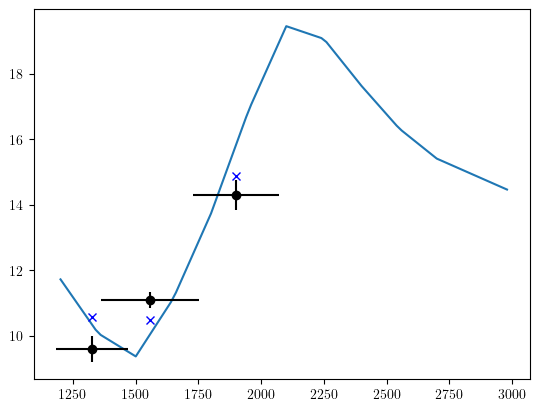

In [9]:
lam_grid = np.arange(1200., 3000., 20.)*u.AA
plt.plot(lam_grid, 100*pw.p((tang_grid[i]*np.ones(lam_grid.shape), cang_grid[j]*np.ones(lam_grid.shape), iang_grid[k]*np.ones(lam_grid.shape), lam_grid)))

wid = "W0116-0505"
for bname in op.pfrac[wid].keys():
    plt.errorbar([bands.bp[bname].barlam().value/(1+op.z[wid])], [op.pfrac[wid][bname]], xerr=[bands.bp[bname].rectwidth().value/2./(1+op.z[wid])], yerr=[op.epfrac[wid][bname]], marker='o', color='k')

    p_mod = pw.p_bb(bands.bp[bname], [tang_grid[i]], [cang_grid[j]], [iang_grid[k]], specs.lam_obs[wid], specs.flam[wid], op.z[wid])
    plt.plot([bands.bp[bname].barlam().value/(1+op.z[wid])], [p_mod[0,0,0]*100], 'bx')

In [10]:
chi2_all = np.zeros(chi2_map[op.wids[0]].shape[:2])
for wid in op.wids:
    for i in range(len(tang_grid)):
        for j in range(len(cang_grid)):
            chi2_all[i,j] += np.min(chi2_map[wid][i,j,:])

In [11]:
i, j = np.unravel_index(np.argmin(chi2_all, axis=None), chi2_all.shape)
print(tang_grid[i], cang_grid[j], chi2_all.min())
for wid in op.wids:
    print(wid, iang_grid[np.argmin(chi2_map[wid][i,j])], np.min(chi2_map[wid][i,j]))

65.0 deg 17.5 deg 20.193317374968817
W0019-1046 62.5 deg 0.010544446364212732
W0204-0506 82.5 deg 0.5180224597186713
W0220+0137 82.5 deg 0.01327770062537003
W0831+0140 67.5 deg 2.450841449152721
W0116-0505 72.5 deg 17.200631319107842


In [12]:
chi2_all_masked = np.zeros(chi2_map[op.wids[0]].shape[:2])
for wid in op.wids:
    for i, tang in enumerate(tang_grid):
        for j, cang in enumerate(cang_grid):
            if tang>cang:
                cond = iang_grid>tang
                chi2_all_masked[i,j] += np.min(chi2_map[wid][i,j,cond])
            else:
                chi2_all_masked[i,j] = np.inf

In [13]:
i, j = np.unravel_index(np.argmin(chi2_all_masked, axis=None), chi2_all.shape)
print(tang_grid[i], cang_grid[j], chi2_all_masked.min())
for wid in op.wids:
    print(wid, iang_grid[np.argmin(chi2_map[wid][i,j])], np.min(chi2_map[wid][i,j]))

37.5 deg 17.5 deg 20.589585313958832
W0019-1046 42.5 deg 0.28546592696615725
W0204-0506 80.0 deg 0.004776223001196346
W0220+0137 77.5 deg 0.014146274250555507
W0831+0140 52.5 deg 0.06535684647079618
W0116-0505 65.0 deg 20.219840043270125


In [14]:
#Set the additional SKIRTOR models we want to plot for W0116-0505. 
wid = "W0116-0505"
other_sk_models = [
    {"d03_mod":"MW"},
    {"d03_mod":"LMC"},
    {"d03_mod":"SMC"},
    {"gs_min":0.1, "gs_max":1, "a":0.0},
    {"gs_min":0.1, "gs_max":1, "a":3.5},
    {"gs_min":0.1, "gs_max":1, "a":3.5, "sil":True},
]
other_sk = list()
other_chi2 = list()
for oskm in other_sk_models:
    other_sk.append(LoadSKIRTOR_General(**oskm))
    chi2_aux = np.zeros(len(iang_grid))
    for bname in op.pfrac[wid].keys():
        p_aux = other_sk[-1].p_bb(bands.bp[bname], iang_grid, specs.lam_obs[wid], specs.flam[wid], specs.specs.sp[wid].zspec)
        chi2_aux += ((p_aux*100 - op.pfrac[wid][bname])/op.epfrac[wid][bname])**2
    other_chi2.append(chi2_aux)


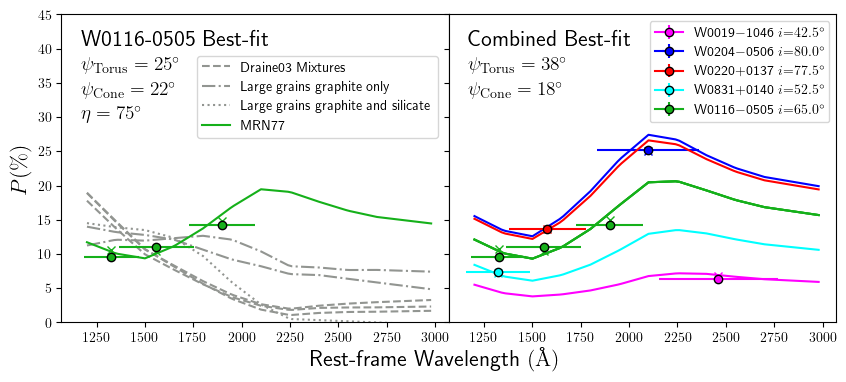

In [15]:
colors = {"W0116-0505":"xkcd:green", "W0019-1046":"magenta", "W0204-0506":"blue", "W0220+0137":"red", "W0831+0140":"cyan"}

fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0., hspace=0.)

#On one plot, we show the best solution for W0116-0505. 
lam_grid = np.arange(1200., 3000., 20.)*u.AA
wid = "W0116-0505"

labels = ['Draine03 Mixtures', None, None, 'Large grains graphite only', None, 'Large grains graphite and silicate']
for mm, osk in enumerate(other_sk):
    kk = np.argmin(other_chi2[mm])
    ls = 'dashed'
    if mm>2 and mm<5:
        ls = 'dashdot'
    elif mm==5:
        ls = 'dotted'
    axs[0].plot(lam_grid, 100*osk.p((iang_grid[kk]*np.ones(lam_grid.shape), lam_grid)), c='xkcd:grey',ls=ls, label=labels[mm])
i1, j1, k1 = np.unravel_index(np.argmin(chi2_map[wid], axis=None), chi2_map[wid].shape)
axs[0].plot(lam_grid, 100*pw.p((tang_grid[i1]*np.ones(lam_grid.shape), cang_grid[j1]*np.ones(lam_grid.shape), iang_grid[k1]*np.ones(lam_grid.shape), lam_grid)), c=colors[wid],ls='solid', label='MRN77')

for bname in op.pfrac[wid].keys():

    axs[0].errorbar([bands.bp[bname].barlam().value/(1+op.z[wid])], [op.pfrac[wid][bname]], xerr=[bands.bp[bname].rectwidth().value/2./(1+op.z[wid])], yerr=[op.epfrac[wid][bname]], marker='o', c=colors[wid], markeredgecolor='black')

    p_mod = pw.p_bb(bands.bp[bname], [tang_grid[i1]], [cang_grid[j1]], [iang_grid[k1]], specs.lam_obs[wid], specs.flam[wid], op.z[wid])
    axs[0].plot([bands.bp[bname].barlam().value/(1+op.z[wid])], [p_mod[0,0,0]*100], c=colors[wid], marker='x')

axs[0].text(0.05, 0.9, "W0116-0505 Best-fit", transform=axs[0].transAxes, fontsize=16, weight='bold')
axs[0].text(0.05, 0.82, r"$\psi_{{\rm Torus}} = {:.0f}^{{\circ}}$".format(tang_grid[i1].value), transform=axs[0].transAxes, fontsize=14)
axs[0].text(0.05, 0.74, r"$\psi_{{\rm Cone}}  = {:.0f}^{{\circ}}$".format(cang_grid[j1].value), transform=axs[0].transAxes, fontsize=14)
axs[0].text(0.05, 0.66, r"$\eta = {:.0f}^{{\circ}}$".format(iang_grid[k1].value), transform=axs[0].transAxes, fontsize=14)

axs[0].legend(loc=(0.35, 0.6))

#On the other, we will show the combined best fit.  
lam_grid = np.arange(1200., 3000., 20.)*u.AA
for wid in op.wids:
    i2, j2 = np.unravel_index(np.argmin(chi2_all_masked, axis=None), chi2_all.shape)
    for bname in op.pfrac[wid].keys():

        k2 = np.argmin(chi2_map[wid][i2,j2,:])

        if bname == "R_SPECIAL":
            label = r"{} $i$=${}^{{\circ}}$".format(re.sub("-","$-$",wid), iang_grid[k2].value)
        else:
            label = None

        axs[1].plot(lam_grid, 100*pw.p((tang_grid[i2]*np.ones(lam_grid.shape), cang_grid[j2]*np.ones(lam_grid.shape), iang_grid[k2]*np.ones(lam_grid.shape), lam_grid)), c=colors[wid],ls='solid')

        axs[1].errorbar([bands.bp[bname].barlam().value/(1+op.z[wid])], [op.pfrac[wid][bname]], xerr=[bands.bp[bname].rectwidth().value/2./(1+op.z[wid])], yerr=[op.epfrac[wid][bname]], marker='o', color=colors[wid], markeredgecolor='black', label=label)

        p_mod = pw.p_bb(bands.bp[bname], [tang_grid[i2]], [cang_grid[j2]], [iang_grid[k2]], specs.lam_obs[wid], specs.flam[wid], op.z[wid])
        axs[1].plot([bands.bp[bname].barlam().value/(1+op.z[wid])], [p_mod[0,0,0]*100], c=colors[wid], marker='x')

axs[1].text(0.05, 0.9, "Combined Best-fit", transform=axs[1].transAxes, fontsize=16, weight='bold')
axs[1].text(0.05, 0.82, r"$\psi_{{\rm Torus}} = {:.0f}^{{\circ}}$".format(tang_grid[i2].value), transform=axs[1].transAxes, fontsize=14)
axs[1].text(0.05, 0.74, r"$\psi_{{\rm Cone}}  = {:.0f}^{{\circ}}$".format(cang_grid[j2].value), transform=axs[1].transAxes, fontsize=14)
#axs[1].text(0.05, 0.66, r"$\eta = {:.0f}^{{\circ}}$".format(iang_grid[k1].value), transform=axs[1].transAxes, fontsize=14)
axs[1].legend()

axs[0].set_ylim([0., 45.])

axs[0].set_ylabel(r"$P (\%)$", fontsize=16)
fig.text(0.5, 0., r"Rest-frame Wavelength $(\rm \AA)$", ha='center', fontsize=16)

fig.savefig("SKIRTOR_MRN77_best-fit.png", dpi=100, bbox_inches='tight')


In [16]:
wid = 'W0204-0506'
kk = np.argmin(chi2_map[wid][0,0,:])
iang_grid[kk], chi2_map[wid][0,0,kk]

(<Quantity 45. deg>, 0.18434051531969092)